<h1 id="aa" align="center" style="color:white;background:#8B0000;padding:18px;border-radius:15px 50px; font-family:newtimeroman;">
    Классификация новостей по категориям (Lenta.Ru News Dataset)
</h1>

<h1 id="bb" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Вступление
</h1>
<p>
    В данной работе рассматривается задача классификации новостей на русском языке по тематическим категориям. Используется датасет Lenta.Ru, содержащий новости с различными метками тем. Цель - определить ключевые признаки, влияющие на классификацию, и подготовить структуру данных для дальнейшего обучения моделей.
</p>

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Цели этапа
</h1>
<ul>
    <li>Определить необходимые поля в датасете для классификации новостей.</li>
    <li>Проанализировать качество и полноту данных.</li>
    <li>Выделить признаки с наибольшим влиянием на классификацию.</li>
    <li>Обосновать исключение или сохранение дополнительных атрибутов.</li>
</ul>


### 1. Загрузка и первичный осмотр данных

In [1]:
import polars as pl
import re
import spacy
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from tqdm import tqdm

In [2]:
df = pl.read_csv('lenta-ru-news.csv')
df_с = pl.read_csv('output_tokenized.csv')


In [3]:
#Посмотреть первые строки таблицы:

In [4]:
print(df.head())

shape: (5, 6)
┌──────────────────┬──────────────────┬─────────────────┬────────────┬────────────────┬────────────┐
│ url              ┆ title            ┆ text            ┆ topic      ┆ tags           ┆ date       │
│ ---              ┆ ---              ┆ ---             ┆ ---        ┆ ---            ┆ ---        │
│ str              ┆ str              ┆ str             ┆ str        ┆ str            ┆ str        │
╞══════════════════╪══════════════════╪═════════════════╪════════════╪════════════════╪════════════╡
│ https://lenta.ru ┆ 1914. Русские    ┆ Бои у Сопоцкина ┆ Библиотека ┆ Первая мировая ┆ 1914/09/16 │
│ /news/1914/09/…  ┆ войска вступили  ┆ и Друскеник за… ┆            ┆                ┆            │
│                  ┆ …                ┆                 ┆            ┆                ┆            │
│ https://lenta.ru ┆ 1914.            ┆ Министерство    ┆ Библиотека ┆ Первая мировая ┆ 1914/09/16 │
│ /news/1914/09/…  ┆ Празднование     ┆ народного       ┆            ┆       

In [5]:
#Посмотреть размерность датасета:
print(df.shape)

(800975, 6)


<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Описание набора данных
</h1>
<p>
    Датасет содержит 800 975 новостей с 6 основными полями:
</p>
<ul>
    <li><strong>url</strong> - ссылка на новость;</li>
    <li><strong>title</strong> - заголовок новости;</li>
    <li><strong>text</strong> - полный текст новости;</li>
    <li><strong>topic</strong> - категория новости (целевая метка);</li>
    <li><strong>tags</strong> - дополнительные теги;</li>
    <li><strong>date</strong> - дата публикации.</li>
</ul>
<p>Типы данных - все строковые (object). Пропуски присутствуют в столбцах <code>topic</code> (~7.7%) и <code>tags</code> (~3.4%).</p>


###  2. Проверка на пропуски и дубликаты

In [6]:
#Проверить количество пропущенных значений по столбцам:
print(df.select(pl.all().is_null().sum()))

shape: (1, 6)
┌─────┬───────┬──────┬───────┬───────┬──────┐
│ url ┆ title ┆ text ┆ topic ┆ tags  ┆ date │
│ --- ┆ ---   ┆ ---  ┆ ---   ┆ ---   ┆ ---  │
│ u32 ┆ u32   ┆ u32  ┆ u32   ┆ u32   ┆ u32  │
╞═════╪═══════╪══════╪═══════╪═══════╪══════╡
│ 0   ┆ 0     ┆ 5    ┆ 62002 ┆ 27219 ┆ 0    │
└─────┴───────┴──────┴───────┴───────┴──────┘


In [7]:
#Проверить наличие дублирующихся строк:
num_duplicates = df.shape[0] - df.unique().shape[0]
print(num_duplicates)

0


### 3. Получить список столбцов и их типы

In [8]:
print(df.columns)

['url', 'title', 'text', 'topic', 'tags', 'date']


<h1 id="aa" align="center" style="color:white;background:#8B0000;padding:18px;border-radius:15px 50px; font-family:newtimeroman;">
    Итоги анализа исходного датасета
</h1>

<ul style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    <li><strong>Размер датасета:</strong> 800 975 строк, 6 столбцов</li>
    <li><strong>Столбцы:</strong> <code>url</code>, <code>title</code>, <code>text</code>, <code>topic</code>, <code>tags</code>, <code>date</code></li>
    <li><strong>Пропуски:</strong>
        <ul>
            <li><code>text</code> - 5 пропусков (почти отсутствуют)</li>
            <li><code>topic</code> - 62 002 пропуска (~7.7%)</li>
            <li><code>tags</code> - 27 219 пропусков (~3.4%)</li>
        </ul>
    </li>
    <li><strong>Дубликаты:</strong> отсутствуют (0)</li>
    <li><strong>Типы данных:</strong> все столбцы имеют тип <code>object</code> (строки)</li>
    <li><strong>Категории (<code>topic</code>):</strong> присутствуют, но с большим числом пропусков, требуется дополнительный анализ распределения</li>
</ul>


# 1. Анализ целевой переменной topic
# Посмотрим распределение категорий в topic:

In [9]:
print(df['topic'].value_counts())
# Это поможет понять, какие категории есть, насколько они сбалансированы и стоит ли исключать редкие категории.

shape: (24, 2)
┌───────────────────┬───────┐
│ topic             ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│ Путешествия       ┆ 6408  │
│ ЧМ-2014           ┆ 2     │
│ МедНовости        ┆ 1     │
│ Крым              ┆ 666   │
│ Культпросвет      ┆ 340   │
│ …                 ┆ …     │
│ Дом               ┆ 21734 │
│ Наука и техника   ┆ 53136 │
│ Силовые структуры ┆ 19596 │
│ Сочи              ┆ 1     │
│ Библиотека        ┆ 65    │
└───────────────────┴───────┘


# Анализ пропусков в topic и tags 
## Нужно решить, что делать с пропусками в topic - это целевая переменная, поэтому строки с пропусками в ней лучше удалить:

In [10]:
df = df.filter(pl.col("topic").is_not_null())

# Пропуски в tags можно игнорировать на данном этапе, так как этот столбец не является обязательным для классификации.

# 3. Анализ текстовых данных

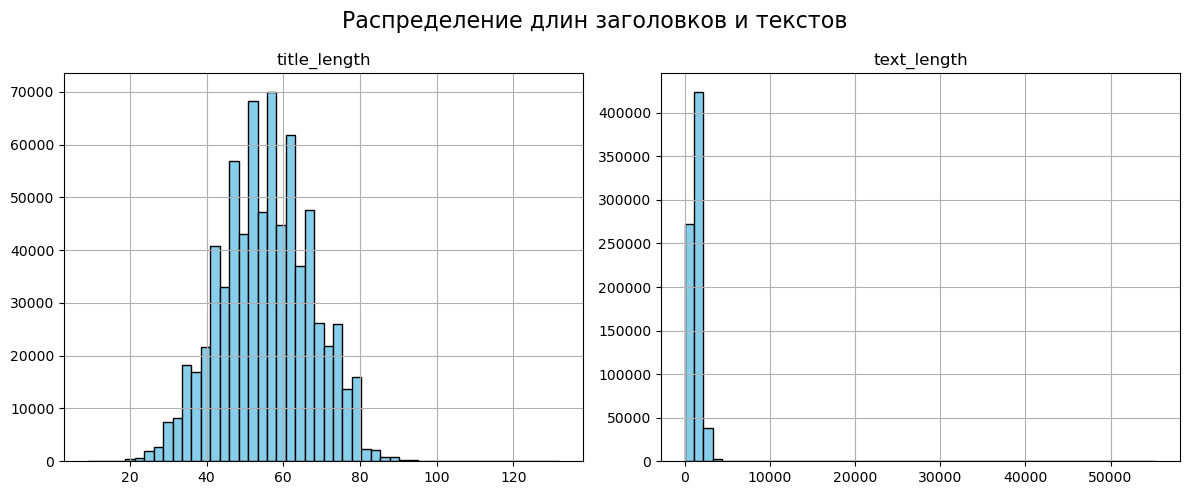

In [11]:
import matplotlib.pyplot as plt

df = df.with_columns([
    pl.col("title").str.len_chars().alias("title_length"),
    pl.col("text").str.len_chars().alias("text_length")
])
pdf = df.select(["title_length", "text_length"]).to_pandas()
pdf.hist(bins=50, figsize=(12, 5), color='skyblue', edgecolor='black')
plt.suptitle("Распределение длин заголовков и текстов", fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
title_stats = df["title_length"].describe()
text_stats = df["text_length"].describe()

print("Статистика по длине заголовков:")
print(title_stats)

print("\nСтатистика по длине текстов:")
print(text_stats)

# Распределение длин заголовков (частоты)
title_length_counts = df.group_by("title_length").agg(pl.count().alias("frequency")).sort("title_length")
print("\nРаспределение длины заголовков (длина : количество):")
print(title_length_counts.head(20))

# Распределение длин текстов (частоты)
text_length_counts = df.group_by("text_length").agg(pl.count().alias("frequency")).sort("text_length")
print("\nРаспределение длины текстов (длина : количество):")
print(text_length_counts.head(20))

Статистика по длине заголовков:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 738973.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 55.657778 │
│ std        ┆ 11.890203 │
│ min        ┆ 9.0       │
│ 25%        ┆ 47.0      │
│ 50%        ┆ 56.0      │
│ 75%        ┆ 64.0      │
│ max        ┆ 132.0     │
└────────────┴───────────┘

Статистика по длине текстов:
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 738968.0    │
│ null_count ┆ 5.0         │
│ mean       ┆ 1335.105309 │
│ std        ┆ 554.546435  │
│ min        ┆ 3.0         │
│ 25%        ┆ 976.0       │
│ 50%        ┆ 1257.0      │
│ 75%        ┆ 1606.0      │
│ max        ┆ 55387.0     │
└────────────┴─────────────┘

Распределение длины заголовков (длина : количество):
shape: (20, 2)
┌

/var/folders/dq/ms57v47d7c3_4kj92m1m8j940000gn/T/ipykernel_68340/2972914541.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  title_length_counts = df.group_by("title_length").agg(pl.count().alias("frequency")).sort("title_length")
/var/folders/dq/ms57v47d7c3_4kj92m1m8j940000gn/T/ipykernel_68340/2972914541.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  text_length_counts = df.group_by("text_length").agg(pl.count().alias("frequency")).sort("text_length")


<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Анализ распределения длины заголовков и текстов
</h1>

<h2 style="font-family:newtimeroman; color:#8B0000;">Распределение длины заголовков</h2>
<ul style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    <li>Заголовков длиной от <strong>9 до 30 символов</strong> насчитывается от 1 до 2384 штук на каждую длину.</li>
    <li>Наблюдается тенденция роста количества заголовков с увеличением длины до примерно 30 символов.</li>
    <li>Большинство заголовков имеют длину в диапазоне <strong>примерно 20–30 символов</strong>.</li>
    <li>Это свидетельствует о том, что заголовки в датасете в основном <strong>достаточно информативные и не слишком короткие</strong>.</li>
</ul>

<h2 style="font-family:newtimeroman; color:#8B0000;">Распределение длины текстов</h2>
<ul style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    <li>Присутствует небольшое количество очень коротких текстов длиной от <strong>3 до 22 символов</strong>, но таких новостей мало - от 8 до 321 на каждую длину.</li>
    <li>Большинство текстов значительно длиннее - средняя длина составляет около <strong>1300 символов</strong>.</li>
    <li>Короткие тексты, скорее всего, являются шумом или неполными данными, поэтому их рекомендуется <strong>удалить или обработать отдельно</strong>.</li>
</ul>

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Статистические показатели длины заголовков и текстов
</h1>

<table style="border-collapse: collapse; width: 60%; margin: 20px 0; font-family:newtimeroman; font-size:16px;">
  <thead style="background:#8B0000; color:white;">
    <tr>
      <th style="border: 2px solid #B00000; padding: 10px;">Показатель</th>
      <th style="border: 2px solid #B00000; padding: 10px;">Длина заголовков (символы)</th>
      <th style="border: 2px solid #B00000; padding: 10px;">Длина текстов (символы)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #B00000; padding: 8px;">Количество (count)</td>
      <td style="border: 1px solid #B00000; padding: 8px;">738 973</td>
      <td style="border: 1px solid #B00000; padding: 8px;">738 968</td>
    </tr>
    <tr>
      <td style="border: 1px solid #B00000; padding: 8px;">Среднее (mean)</td>
      <td style="border: 1px solid #B00000; padding: 8px;">55.66</td>
      <td style="border: 1px solid #B00000; padding: 8px;">1335.11</td>
    </tr>
    <tr>
      <td style="border: 1px solid #B00000; padding: 8px;">Стандартное отклонение (std)</td>
      <td style="border: 1px solid #B00000; padding: 8px;">11.89</td>
      <td style="border: 1px solid #B00000; padding: 8px;">554.55</td>
    </tr>
    <tr>
      <td style="border: 1px solid #B00000; padding: 8px;">Минимум (min)</td>
      <td style="border: 1px solid #B00000; padding: 8px;">9</td>
      <td style="border: 1px solid #B00000; padding: 8px;">3</td>
    </tr>
    <tr>
      <td style="border: 1px solid #B00000; padding: 8px;">25-й перцентиль (25%)</td>
      <td style="border: 1px solid #B00000; padding: 8px;">47</td>
      <td style="border: 1px solid #B00000; padding: 8px;">976</td>
    </tr>
    <tr>
      <td style="border: 1px solid #B00000; padding: 8px;">Медиана (50%)</td>
      <td style="border: 1px solid #B00000; padding: 8px;">56</td>
      <td style="border: 1px solid #B00000; padding: 8px;">1257</td>
    </tr>
    <tr>
      <td style="border: 1px solid #B00000; padding: 8px;">75-й перцентиль (75%)</td>
      <td style="border: 1px solid #B00000; padding: 8px;">64</td>
      <td style="border: 1px solid #B00000; padding: 8px;">1606</td>
    </tr>
    <tr>
      <td style="border: 1px solid #B00000; padding: 8px;">Максимум (max)</td>
      <td style="border: 1px solid #B00000; padding: 8px;">132</td>
      <td style="border: 1px solid #B00000; padding: 8px;">55387</td>
    </tr>
  </tbody>
</table>


# 4. Проверка качества данных

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Проверка качества данных
</h1>
<p style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    В ходе проверки качества данных была выявлена минимальная доля новостей с отсутствующим текстом (<code>text</code>) - всего 5 записей из более 800 тысяч. При этом пустых заголовков (<code>title</code>) не обнаружено.
</p>
<p style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    Анализ примеров с пропущенным текстом показал, что такие записи содержат заголовки и метки категорий, но отсутствует основной текст новости, что делает их непригодными для обучения модели.
</p>
<p style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    <strong>Вывод:</strong> данные с пропущенным текстом необходимо удалить, чтобы избежать искажений в обучении. В остальном качество текстовых данных высокое, что обеспечивает надежную основу для построения модели классификации.
</p>


# Что делать дальше?

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    1. Очистка данных
</h1>
<ul style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    <li><strong>Удалить строки с пропущенными текстами</strong>, чтобы исключить неполные или некорректные данные.</li>
</ul>

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    2. Подготовка данных для обучения
</h1>
<ul style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    <li><strong>Оставить только необходимые столбцы:</strong> <code>title</code>, <code>text</code>, <code>topic</code> - ключевые для классификации.</li>
    <li><strong>Объединить заголовок и текст</strong> в один общий текстовый признак для подачи в модель, что повысит информативность входных данных.</li>
</ul>

In [13]:
# 1. Удаляем строки с пропущенным текстом
df_clean = df.filter(pl.col("text").is_not_null())

# 2. Добавляем длину текста
df_clean = df_clean.with_columns(
    pl.col("text").str.len_chars().alias("text_length")
)

# 3. Удаляем очень короткие тексты
df_clean = df_clean.filter(pl.col("text_length") > 50)

# 4. Исключаем редкие категории (<500 новостей)
topic_counts = df_clean.group_by("topic").agg(pl.len().alias("count"))
rare_topics = topic_counts.filter(pl.col("count") < 500)["topic"].to_list()
df_clean = df_clean.filter(~pl.col("topic").is_in(rare_topics))
    
# 5. Объединяем заголовок и текст
df_clean = df_clean.with_columns(
    (pl.col("title") + ". " + pl.col("text")).alias("full_text")
)

# 6. Выводим размер итогового датасета
print("Размер датасета после очистки:", df_clean.shape[0])

# 7. Вывод уникальных категорий
unique_topics = df_clean["topic"].unique().to_list()
print("Уникальные категории после очистки:", unique_topics)

# 8. Примеры данных
print("\nПримеры данных:")
print(df_clean.select(["full_text", "topic"]).head(5))

Размер датасета после очистки: 737035
Уникальные категории после очистки: ['Крым', 'Путешествия', 'Бизнес', 'Культура', 'Из жизни', 'Силовые структуры', 'Интернет и СМИ', 'Бывший СССР', 'Россия', 'Мир', 'Дом', 'Экономика', '69-я параллель', 'Наука и техника', 'Спорт', 'Ценности']

Примеры данных:
shape: (5, 2)
┌─────────────────────────────────┬────────┐
│ full_text                       ┆ topic  │
│ ---                             ┆ ---    │
│ str                             ┆ str    │
╞═════════════════════════════════╪════════╡
│ Космонавты сомневаются в надеж… ┆ Россия │
│ Взрыв в центре Москвы: пострад… ┆ Россия │
│ Япония кредитует Россию на пол… ┆ Россия │
│ Британцы отмечают двухлетие см… ┆ Мир    │
│ Отмытые через Bank of NY деньг… ┆ Россия │
└─────────────────────────────────┴────────┘



<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Анализ и выбор признаков
</h1>
<ul>
    <li><strong>Оставлены для обучения:</strong> <code>title</code>, <code>text</code>, <code>topic</code> - ключевые для тематической классификации.</li>
    <li><strong>Исключены:</strong> <code>url</code>, <code>tags</code>, <code>date</code> - технические или малоинформативные для классификации.</li>
    <li>Удалены строки с пропущенными значениями в <code>topic</code>, так как это целевая переменная.</li>
    <li>Проверены длины текстов и заголовков: средняя длина заголовка ~56 символов, текста ~1332 символа, что достаточно для анализа.</li>
    <li>Удалены новости с очень короткими текстами (<50 символов) для повышения качества обучения.</li>
    <li>Исключены редкие категории с количеством новостей менее 500 для исключения шума.</li>
</ul>

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Итоговая структура набора данных
</h1>
<table style="border-collapse: collapse; width: 100%; margin: 20px 0;">
  <tr style="background:#B00000; color:white;">
    <th style="border: 2px solid #B00000; padding: 10px;">Поле</th>
    <th style="border: 2px solid #B00000; padding: 10px;">Описание</th>
    <th style="border: 2px solid #B00000; padding: 10px;">Использование</th>
  </tr>
  <tr>
    <td style="border: 1px solid #B00000; padding: 8px;">title</td>
    <td style="border: 1px solid #B00000; padding: 8px;">Заголовок новости</td>
    <td style="border: 1px solid #B00000; padding: 8px;">Входной признак</td>
  </tr>
  <tr>
    <td style="border: 1px solid #B00000; padding: 8px;">text</td>
    <td style="border: 1px solid #B00000; padding: 8px;">Полный текст новости</td>
    <td style="border: 1px solid #B00000; padding: 8px;">Входной признак</td>
  </tr>
  <tr>
    <td style="border: 1px solid #B00000; padding: 8px;">topic</td>
    <td style="border: 1px solid #B00000; padding: 8px;">Категория новости</td>
    <td style="border: 1px solid #B00000; padding: 8px;">Целевая переменная</td>
  </tr>
</table>

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Выводы
</h1>
<p>
    В результате анализа датасета Lenta.Ru были определены ключевые признаки для классификации новостей - заголовок и текст. Исключение технических и малоинформативных полей улучшит качество обучения и снизит шум. Удаление редких категорий и новостей с пропусками в целевой переменной обеспечит более сбалансированную и чистую выборку. Данные готовы для последующей предобработки и построения моделей классификации.
</p>

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Обоснование выбора признаков для классификации
</h1>

<p style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    Для задачи классификации новостей ключевыми признаками являются <strong>заголовок (title)</strong> и <strong>текст новости (text)</strong>, так как именно они содержат основное смысловое и тематическое содержание материала.
</p>

<p style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    <strong>Почему не используются теги и дата:</strong>
</p>
<ul style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    <li><strong>Теги (tags)</strong> часто неполные, содержат пропуски (~3.4%) и не всегда стандартизированы, что снижает их информативность и усложняет обработку.</li>
    <li><strong>Дата (date)</strong> отражает только время публикации и не несет прямой смысловой нагрузки, релевантной тематике новости, если задача не связана с анализом временных трендов.</li>
</ul>

<p style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
    Таким образом, использование только <code>title</code> и <code>text</code> позволяет сосредоточиться на содержательной части новости, что повышает качество и точность классификации.
</p>


<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
    Предобработка данных датасета
</h1>

<p style="font-family:newtimeroman; font-size:16px; line-height:1.6;">
     Для начала напишем функции для начальной обработки данных. Функция <code>remove_punctuation</code>
</p>

In [14]:
import string
import re

df_clean = df_clean.with_columns(
    pl.col("full_text").str.replace_all(r"[\p{P}\d❯\xa0—«»]+", " ").alias("text_pred")
)
df_clean

url,title,text,topic,tags,date,title_length,text_length,full_text,text_pred
str,str,str,str,str,str,u32,u32,str,str
"""https://lenta.ru/news/1999/08/…","""Космонавты сомневаются в надеж…","""Как стало известно агентству А…","""Россия""","""Все""","""1999/08/31""",42,1429,"""Космонавты сомневаются в надеж…","""Космонавты сомневаются в надеж…"
"""https://lenta.ru/news/1999/08/…","""Взрыв в центре Москвы: пострад…","""В зале игровых автоматов в тре…","""Россия""","""Все""","""1999/08/31""",44,1113,"""Взрыв в центре Москвы: пострад…","""Взрыв в центре Москвы пострад…"
"""https://lenta.ru/news/1999/08/…","""Япония кредитует Россию на пол…","""Япония приняла решение разморо…","""Россия""","""Все""","""1999/08/31""",53,1517,"""Япония кредитует Россию на пол…","""Япония кредитует Россию на пол…"
"""https://lenta.ru/news/1999/08/…","""Британцы отмечают двухлетие см…","""Британцы отмечают сегодня скор…","""Мир""","""Все""","""1999/08/31""",40,2459,"""Британцы отмечают двухлетие см…","""Британцы отмечают двухлетие см…"
"""https://lenta.ru/news/1999/08/…","""Отмытые через Bank of NY деньг…","""В понедельник директор департа…","""Россия""","""Все""","""1999/08/31""",56,2085,"""Отмытые через Bank of NY деньг…","""Отмытые через Bank of NY деньг…"
…,…,…,…,…,…,…,…,…,…
"""https://lenta.ru/news/2018/12/…","""«Желтые жилеты» прорвали кордо…","""Протесты движения «желтых жиле…","""Мир""","""Происшествия""","""2018/12/15""",56,674,"""«Желтые жилеты» прорвали кордо…",""" Желтые жилеты прорвали кордо…"
"""https://lenta.ru/news/2018/12/…","""Су-27 разбился на Украине""","""Истребитель Су-27 разбился в Ж…","""Бывший СССР""","""Украина""","""2018/12/15""",25,613,"""Су-27 разбился на Украине. Ист…","""Су разбился на Украине Истреб…"
"""https://lenta.ru/news/2018/12/…","""В Петербурге нашли квартиру из…","""В Московском районе Санкт-Пете…","""Дом""","""Квартира""","""2018/12/15""",40,1620,"""В Петербурге нашли квартиру из…","""В Петербурге нашли квартиру из…"


<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
   Токенизация лемматизированного текста и удаление стоп-слов
</h1>

In [15]:
nlp = spacy.load("ru_core_news_sm", disable=["parser", "ner", "textcat", "attribute_ruler"])

russian_stopwords = nlp.Defaults.stop_words



In [16]:
# # df_clean['text_tokenize'] = [tokenize(text) for text in df_clean['text_pred']]

# # df_clean['text_tokenize'].head(5)


# def tokenize(texts: pl.Series):
#     processed = []
#     for doc in nlp.pipe(texts.to_list(), batch_size=512, n_process=7):
#         tokens = [
#             token.lemma_
#             for token in doc
#             if not token.is_punct and token.text not in russian_stopwords     # токенизация, лематизаця, удаление стопслов посредством spacy
#         ]
#         processed.append(" ".join(tokens))
#     return pl.Series(processed)

# df_clean = df_clean.with_columns(
#     pl.col("text")
#       .map_batches(tokenize, return_dtype=pl.Utf8)
#       .alias("text_tokenize")
# )

# df_clean.write_csv("output_tokenized.csv")          


<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
Тематическое моделиирование
</h1>

In [17]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import gensim


texts = df_с['text_tokenize'].str.split(" ").to_list()

gensim_dictionary = gensim.corpora.Dictionary(texts)
gensim_dictionary.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary.compactify()

corpus = [gensim_dictionary.doc2bow(text) for text in texts]

lda_20 = gensim.models.LdaMulticore(
    corpus,
    num_topics=10,
    id2word=gensim_dictionary,
    passes=10,
    random_state=6457
)

In [18]:
vis_20 = gensimvis.prepare(lda_20, corpus, gensim_dictionary)

pyLDAvis.enable_notebook()

/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=68340) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=68340) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=68340) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=68340) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationW

In [19]:
vis_20

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.133612  0.196398       1        1  12.320421
9      0.026792 -0.044804       2        1  12.190343
4     -0.114548  0.068544       3        1  12.076025
2      0.026039 -0.110145       4        1  10.720603
8      0.132673  0.143081       5        1  10.434761
6      0.018182 -0.143739       6        1  10.376426
0      0.190927 -0.025705       7        1  10.325781
5      0.063616  0.100303       8        1   8.308033
7      0.001562 -0.087280       9        1   6.836103
1     -0.211632 -0.096653      10        1   6.411505, topic_info=            Term           Freq          Total Category  logprob  loglift
7903              302559.000000  302559.000000  Default  30.0000  30.0000
2150     процент  296321.000000  296321.000000  Default  29.0000  29.0000
615      украина  178108.000000  178108.000000  Default  28.0000  28.0000
219       доллар  213975.000000  213975.000000  Default  27.0000  27.0000
479     компания  300587.000000  300587.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
521   российский   39208.239753  305343.701736  Topic10  -5.0425   0.6945
460       второй   26599.390654  108379.048551  Topic10  -5.4305   1.3423
204           Об   34294.628433  396260.755214  Topic10  -5.1764   0.3000
896       пройти   23588.541875  101400.685255  Topic10  -5.5506   1.2888
129          два   23584.692547  233328.979225  Topic10  -5.5508   0.4552

[840 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
198        1  0.120555          
198        2  0.103921          
198        3  0.156975          
198        4  0.129504          
198        5  0.096947          
...      ...       ...       ...
628        9  0.039306  являться
628       10  0.043876  являться
66272      2  0.999151    якунин
61745      6  0.999885  янукович
82751      6  0.999753    яценюк

[2578 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 5, 3, 9, 7, 1, 6, 8, 2])

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">
   Векторизация HashingVectorizer
</h1>

In [20]:
russian_stopwords = list(nlp.Defaults.stop_words)

In [32]:
from sklearn.feature_extraction.text import HashingVectorizer
from joblib import dump

vectorizer = HashingVectorizer(
    ngram_range=(1, 2),
    n_features=800000,  
    stop_words=russian_stopwords,
)

dump(vectorizer, 'vectorizer.joblib')

Y = vectorizer.transform(df_с['text_tokenize'].to_list())

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

X = vectorizer.fit_transform(df_с['text_tokenize'].to_list())
x = df_с['topic'].to_list() 


X_train, X_test, y_train, y_test = train_test_split(X, x, test_size=0.2, random_state=42)

In [ ]:
from joblib import dump

model_sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, max_iter=1000, random_state=42)
model_sgd.fit(X_train, y_train)
y_pred = model_sgd.predict(X_test)

dump(model_sgd, 'sgd_classifier_model.joblib')

print("SGDClassifier:")
print(classification_report(y_test, y_pred))

SGDClassifier:


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00       258
           Бизнес       0.00      0.00      0.00      1446
      Бывший СССР       0.80      0.61      0.69     10763
              Дом       0.90      0.57      0.70      4373
         Из жизни       0.76      0.25      0.38      5490
   Интернет и СМИ       0.76      0.54      0.63      8873
             Крым       0.00      0.00      0.00       115
         Культура       0.82      0.81      0.81     10746
              Мир       0.70      0.86      0.77     27509
  Наука и техника       0.77      0.81      0.79     10376
      Путешествия       1.00      0.01      0.02      1224
           Россия       0.66      0.86      0.75     31990
Силовые структуры       0.85      0.04      0.07      3957
            Спорт       0.95      0.94      0.95     12778
         Ценности       0.99      0.44      0.61      1595
        Экономика       0.74      0.83      0.78     15

/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
model_svc = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=1000, random_state=42)
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

dump(model_svc, 'linearsvc_classifier_model.joblib')

print("LinearSVC:")
print(classification_report(y_test, y_pred))

LinearSVC:
                   precision    recall  f1-score   support

   69-я параллель       0.84      0.59      0.69       258
           Бизнес       0.79      0.55      0.65      1446
      Бывший СССР       0.87      0.90      0.88     10763
              Дом       0.91      0.87      0.89      4373
         Из жизни       0.76      0.65      0.70      5490
   Интернет и СМИ       0.83      0.79      0.81      8873
             Крым       0.87      0.57      0.68       115
         Культура       0.90      0.92      0.91     10746
              Мир       0.85      0.87      0.86     27509
  Наука и техника       0.89      0.90      0.89     10376
      Путешествия       0.85      0.76      0.80      1224
           Россия       0.85      0.87      0.86     31990
Силовые структуры       0.82      0.66      0.73      3957
            Спорт       0.97      0.98      0.97     12778
         Ценности       0.96      0.90      0.93      1595
        Экономика       0.88      0.90      

In [31]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(C=1.0, solver='saga', max_iter=1000, n_jobs=6)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

dump(model_lr, 'LogisticRegression_classifier_model.joblib')

print("Логистическая регрессия:")
print(classification_report(y_test, y_pred))

Логистическая регрессия:
                   precision    recall  f1-score   support

   69-я параллель       0.90      0.38      0.53       258
           Бизнес       0.74      0.47      0.57      1446
      Бывший СССР       0.85      0.86      0.86     10763
              Дом       0.89      0.83      0.86      4373
         Из жизни       0.71      0.65      0.68      5490
   Интернет и СМИ       0.80      0.75      0.77      8873
             Крым       0.67      0.28      0.39       115
         Культура       0.89      0.90      0.89     10746
              Мир       0.83      0.86      0.85     27509
  Наука и техника       0.87      0.88      0.87     10376
      Путешествия       0.83      0.68      0.75      1224
           Россия       0.82      0.86      0.84     31990
Силовые структуры       0.80      0.58      0.67      3957
            Спорт       0.97      0.97      0.97     12778
         Ценности       0.95      0.85      0.90      1595
        Экономика       0.86  